In [136]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import datetime
from tqdm import tqdm
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import LinearSVR
import pickle
from sklearn.metrics import mean_squared_error 
warnings.filterwarnings("ignore")

In [137]:
data = pd.read_excel('covid_19_data.xlsx',sheet_name='per day')
data.head()

,ObservationDate,days,Sum of Confirmed,Sum of Deaths,Sum of Recovered
0,22-Jan,1,555,17,28
1,23-Jan,2,653,18,30
2,24-Jan,3,941,26,36
3,25-Jan,4,1438,42,39
4,26-Jan,5,2118,56,52


In [177]:
X = np.reshape(list(data['days']),(-1, 1))
X_train = X[:int(.9*len(X))]
y = np.reshape(list(data['Sum of Confirmed']),(-1, 1))
y_train = y[:int(.9*len(y))]
X_valid = X[int(.9*len(X)):]
y_valid = y[int(.9*len(y)):]

In [178]:
# define eval metrics
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = y.get_label()
    return "rmspe", rmspe(y,yhat)

## Lasso Regression

In [179]:
lasso_regression = Lasso()
parameters = {'alpha':[10**-5, 10**-4, 10**-3, 10**-2, 0.1, 1, 10, 10**2, 10**3, 10**4, 10**5]}
tscv = TimeSeriesSplit(n_splits=3)
clf = GridSearchCV(lasso_regression, parameters, cv=tscv, scoring='neg_mean_squared_error', verbose = 2, return_train_score=True, n_jobs = -1)
clf.fit(X_train, np.log2(y_train))

results = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  33 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    0.0s finished


In [180]:
train_score= results['mean_train_score']
train_score_std= results['std_train_score']
cv_score = results['mean_test_score'] 
cv_score_std= results['std_test_score']
param_alpha = results['param_alpha']
results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.000997,8.485379e-07,0.000334,4.723819e-04,1e-05,{'alpha': 1e-05},-1.820046,-7.865763,-8.952069,-6.212626,3.137524,7,-1.102613,-0.677302,-1.080107,-0.953341,0.195405
1,0.000664,4.698539e-04,0.000331,4.682234e-04,0.0001,{'alpha': 0.0001},-1.819990,-7.865717,-8.952040,-6.212582,3.137534,6,-1.102613,-0.677302,-1.080107,-0.953341,0.195405
2,0.000993,6.184602e-06,0.000998,7.786718e-07,0.001,{'alpha': 0.001},-1.819425,-7.865267,-8.951751,-6.212147,3.137634,5,-1.102613,-0.677302,-1.080107,-0.953341,0.195405
3,0.000998,3.893359e-07,0.000000,0.000000e+00,0.01,{'alpha': 0.01},-1.813785,-7.860758,-8.948855,-6.207800,3.138632,4,-1.102614,-0.677302,-1.080107,-0.953341,0.195405
4,0.000997,8.140041e-04,0.000665,4.701355e-04,0.1,{'alpha': 0.1},-1.757894,-7.815751,-8.919929,-6.164525,3.148396,3,-1.102659,-0.677314,-1.080112,-0.953362,0.195412


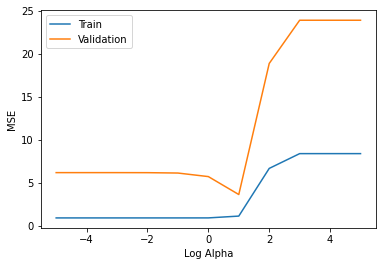

In [181]:
plt.plot(np.log10(param_alpha.astype(float)), np.abs(train_score), label = 'Train')
plt.plot(np.log10(param_alpha.astype(float)), np.abs(cv_score), label = 'Validation')
plt.xlabel('Log Alpha')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [182]:
lasso_regression = Lasso(alpha = 10)
lasso_regression.fit(X_train, np.log1p(y_train))

y_train_pred = lasso_regression.predict(X_train)  
y_valid_pred = lasso_regression.predict(X_valid)
print(rmspe(y_train, np.expm1(y_train_pred)))
print(rmspe(y_valid, np.expm1(y_valid_pred)))

2482.861320501752
2.6563003424497125


In [183]:
print('MSE of train: ',min(np.abs(train_score)))
print('MSE of test: ',min(np.abs(cv_score)))

MSE of train:  0.9533405309044017
MSE of test:  3.6697507813632426


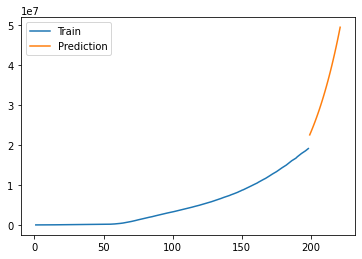

In [185]:
plt.plot(X_train[:,0], y_train, label = 'Train')
plt.plot(X_valid[:,0], np.power(2.6,y_valid_pred), label = 'Prediction')

plt.legend()
plt.show()

## Ridge Regression

In [146]:
ridge_regression = Ridge()
parameters = {'alpha':[10**-5, 10**-4, 10**-3, 10**-2, 0.1, 1, 10, 10**2, 10**3, 10**4, 10**5]}
tscv = TimeSeriesSplit(n_splits=3)
clf = GridSearchCV(ridge_regression, parameters, cv=tscv, scoring='neg_mean_squared_error', verbose = 2, return_train_score=True, n_jobs = -1)
clf.fit(X_train, np.log1p(y_train))

results = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  33 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    0.0s finished


In [147]:
train_score= results['mean_train_score']
train_score_std= results['std_train_score']
cv_score = results['mean_test_score'] 
cv_score_std= results['std_test_score']
param_alpha = results['param_alpha']
results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.001329,0.000469,0.000665,0.00047,1e-05,{'alpha': 1e-05},-0.560992,-6.279486,-8.568761,-5.136413,3.367596,10,-0.378319,-0.242244,-0.682638,-0.4344,0.184111
1,0.001330,0.000470,0.000332,0.00047,0.0001,{'alpha': 0.0001},-0.560992,-6.279486,-8.568761,-5.136413,3.367596,9,-0.378319,-0.242244,-0.682638,-0.4344,0.184111
2,0.000997,0.000814,0.000665,0.00047,0.001,{'alpha': 0.001},-0.560991,-6.279486,-8.568761,-5.136413,3.367596,8,-0.378319,-0.242244,-0.682638,-0.4344,0.184111
3,0.000653,0.000462,0.000665,0.00047,0.01,{'alpha': 0.01},-0.560985,-6.279482,-8.568760,-5.136409,3.367598,7,-0.378319,-0.242244,-0.682638,-0.4344,0.184111
4,0.000997,0.000002,0.000000,0.00000,0.1,{'alpha': 0.1},-0.560929,-6.279449,-8.568749,-5.136375,3.367616,6,-0.378319,-0.242244,-0.682638,-0.4344,0.184111


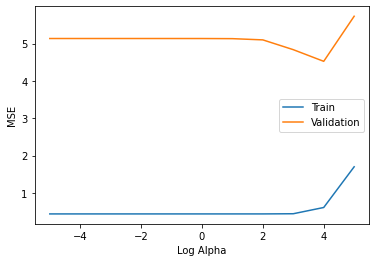

In [148]:
plt.plot(np.log10(param_alpha.astype(float)), np.abs(train_score), label = 'Train')
plt.plot(np.log10(param_alpha.astype(float)), np.abs(cv_score), label = 'Validation')
plt.xlabel('Log Alpha')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [149]:
print('MSE of train: ',min(np.abs(train_score)))
print('MSE of test: ',min(np.abs(cv_score)))

MSE of train:  0.43440033722488786
MSE of test:  4.52484446213577


In [237]:
ridge_regression = Ridge(alpha = 10000)
ridge_regression.fit(X_train, np.log1p(y_train))

y_train_pred = ridge_regression.predict(X_train)  
y_valid_pred = ridge_regression.predict(X_valid)
print(rmspe(y_train, np.expm1(y_train_pred)))
print(rmspe(y_valid, np.expm1(y_valid_pred)))

4.7352331427778225
3.610790089122761


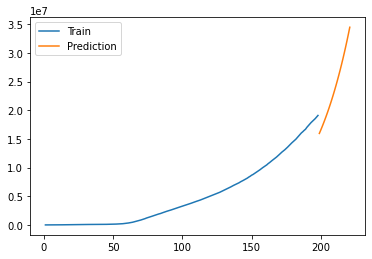

In [192]:
plt.plot(X_train, y_train, label = 'Train')
plt.plot(X_valid, np.power(2.55,y_valid_pred), label = 'Prediction')

plt.legend()
plt.show()

## Linear SVR

In [229]:
svr_regression = LinearSVR()
parameters = {'C':[10**-4, 10**-3, 10**-2, 0.1, 1, 10, 10**2, 10**3, 10**4]}
tscv = TimeSeriesSplit(n_splits=3)
clf = GridSearchCV(svr_regression, parameters, cv=tscv, scoring='neg_mean_squared_error', verbose = 2, return_train_score=True, n_jobs = -1)
clf.fit(X_train, np.log1p(y_train))

results = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.0s finished


In [230]:
train_score= results['mean_train_score']
train_score_std= results['std_train_score']
cv_score = results['mean_test_score'] 
cv_score_std= results['std_test_score']
param_C = results['param_C']
results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.000665,0.000470,0.000333,4.703588e-04,0.0001,{'C': 0.0001},-14.901020,-46.439254,-56.561025,-39.300433,17.740933,5,-49.506857,-19.888163,-22.454568,-30.616529,13.398507
1,0.001662,0.000940,0.000333,4.704712e-04,0.001,{'C': 0.001},-70.241236,-77.594741,-74.161478,-73.999152,3.004249,7,-18.097612,-18.202993,-21.619864,-19.306823,1.636133
2,0.005984,0.006359,0.000998,9.199649e-07,0.01,{'C': 0.01},-95.792382,-75.819002,-71.137634,-80.916339,10.691158,8,-16.260119,-16.630431,-19.131233,-17.340595,1.275166
3,0.005983,0.000814,0.000333,4.702464e-04,0.1,{'C': 0.1},-66.930968,-28.291854,-13.843306,-36.355376,22.410418,4,-9.623077,-5.314646,-3.256112,-6.064612,2.652847
4,0.005983,0.002443,0.000332,4.701340e-04,1,{'C': 1},-1.183592,-2.495135,-10.077825,-4.585518,3.920384,2,-0.540370,-0.357056,-0.723048,-0.540158,0.149416


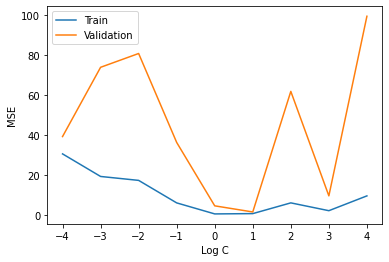

In [231]:
plt.plot(np.log10(param_C.astype(float)), np.abs(train_score), label = 'Train')
plt.plot(np.log10(param_C.astype(float)), np.abs(cv_score), label = 'Validation')
plt.xlabel('Log C')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [232]:
print('MSE of train: ',min(np.abs(train_score)))
print('MSE of test: ',min(np.abs(cv_score)))

MSE of train:  0.5401582111542934
MSE of test:  1.5171056861075616


In [233]:
svr_regression = LinearSVR(C = 1)
svr_regression.fit(X_train, np.log1p(y_train))

y_train_pred = svr_regression.predict(X_train)  
y_valid_pred = svr_regression.predict(X_valid)
print(rmspe(y_train, np.expm1(y_train_pred)))
print(rmspe(y_valid, np.expm1(y_valid_pred)))

6363.051897930776
10.86231613771456


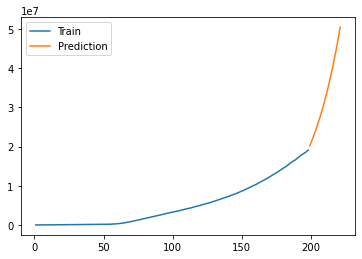

In [235]:
plt.plot(X_train, y_train, label = 'Train')
plt.plot(X_valid, np.power(2.45,y_valid_pred), label = 'Prediction')

plt.legend()
plt.show()

## Decision Tree

In [198]:
decision_tree = DecisionTreeRegressor()

tscv = TimeSeriesSplit(n_splits=3)
parameters = {'min_samples_split':[100, 200, 500], 'max_depth':[10, 20, 30, 50]}
clf = GridSearchCV(decision_tree, parameters, cv=tscv, scoring='neg_mean_squared_error', verbose = 2, return_train_score=True, n_jobs = -1)
clf.fit(X_train, np.log1p(y_train))

results = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    1.5s finished


In [199]:
clf.best_params_

{'max_depth': 10, 'min_samples_split': 100}

In [200]:
train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
param_max_depth = results['param_max_depth']
param_min_samples_split = results['param_min_samples_split']
results.head(8)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.000665,4.702466e-04,0.000664,4.698532e-04,10,100,"{'max_depth': 10, 'min_samples_split': 100}",-12.530295,-2.164511,-2.075380,-5.590062,4.907621,1,-2.110192,-1.475235,-1.289234,-1.624887,0.351463
1,0.000997,2.247832e-07,0.000997,3.371748e-07,10,200,"{'max_depth': 10, 'min_samples_split': 200}",-12.530295,-11.811294,-10.116178,-11.485922,1.012057,5,-2.110192,-4.432802,-5.589869,-4.044288,1.446892
2,0.000998,1.410739e-03,0.000665,4.700217e-04,10,500,"{'max_depth': 10, 'min_samples_split': 500}",-12.530295,-11.811294,-10.116178,-11.485922,1.012057,5,-2.110192,-4.432802,-5.589869,-4.044288,1.446892
3,0.001663,9.399872e-04,0.000000,0.000000e+00,20,100,"{'max_depth': 20, 'min_samples_split': 100}",-12.530295,-2.164511,-2.075380,-5.590062,4.907621,1,-2.110192,-1.475235,-1.289234,-1.624887,0.351463
4,0.000997,3.371748e-07,0.000333,4.703588e-04,20,200,"{'max_depth': 20, 'min_samples_split': 200}",-12.530295,-11.811294,-10.116178,-11.485922,1.012057,5,-2.110192,-4.432802,-5.589869,-4.044288,1.446892
5,0.000665,4.700783e-04,0.000665,4.704153e-04,20,500,"{'max_depth': 20, 'min_samples_split': 500}",-12.530295,-11.811294,-10.116178,-11.485922,1.012057,5,-2.110192,-4.432802,-5.589869,-4.044288,1.446892
6,0.000332,4.695721e-04,0.000665,4.701341e-04,30,100,"{'max_depth': 30, 'min_samples_split': 100}",-12.530295,-2.164511,-2.075380,-5.590062,4.907621,1,-2.110192,-1.475235,-1.289234,-1.624887,0.351463
7,0.000665,4.701347e-04,0.000333,4.703588e-04,30,200,"{'max_depth': 30, 'min_samples_split': 200}",-12.530295,-11.811294,-10.116178,-11.485922,1.012057,5,-2.110192,-4.432802,-5.589869,-4.044288,1.446892


<AxesSubplot:xlabel='param_max_depth', ylabel='param_min_samples_split'>

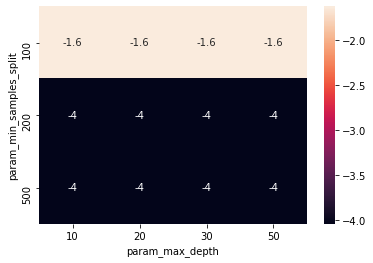

In [201]:
data_train = results.pivot('param_min_samples_split', 'param_max_depth', 'mean_train_score')
sns.heatmap(data_train, annot=True)

<AxesSubplot:xlabel='param_max_depth', ylabel='param_min_samples_split'>

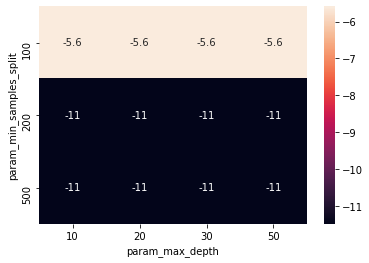

In [202]:
data_train = results.pivot('param_min_samples_split', 'param_max_depth', 'mean_test_score')
sns.heatmap(data_train, annot=True)

In [215]:
best_max_depth = 20
best_min_samples_split = 100

decision_tree = DecisionTreeRegressor(max_depth= best_max_depth, min_samples_split=best_min_samples_split)
decision_tree.fit(X_train, np.log1p(y_train))

y_train_pred = decision_tree.predict(X_train)  
y_valid_pred = decision_tree.predict(X_valid)

In [216]:
print('MSE of train: ',mean_squared_error(np.log1p(y_train), y_train_pred))
print('MSE of test: ',mean_squared_error(np.log1p(y_valid), y_valid_pred))

MSE of train:  0.944041627320382
MSE of test:  0.6721772461931861


In [217]:
print(rmspe(y_train, np.expm1(y_train_pred)))
print(rmspe(y_valid, np.expm1(y_valid_pred)))

1255.7889141130781
0.5576754682866454


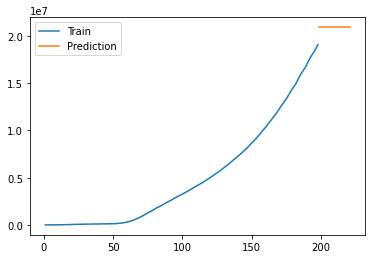

In [210]:
plt.plot(X_train, y_train, label = 'Train')
plt.plot(X_valid, np.power(2.85,y_valid_pred), label = 'Prediction')

plt.legend()
plt.show()